### 1-D Richards equation solver code
- formulation based on a backward Euler implementation of the mixed theta-head formulation of the 1-D Richards equation, with a modified Picard iteration finite differencing solution scheme, with a modified Picard iteration finite differencing solution scheme.

- The soil water retention parameterization used is that of van Genuchten 
 [1980], and this code requires the corresponding MATLAB function        
 vanGenuchten.m.  
 
 - coordinate axis:  positive  downward
         z[0] = 0  (top)
         z[-1] = 100  (bottom)

In [73]:
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import time

In [2]:
%matplotlib inline

In [3]:
def vanGenuchten(h,phi) :
    alpha   = phi[0]
    theta_S = phi[1]
    theta_R = phi[2]
    n       = phi[3]
    m       = phi[4]
    Ksat    = phi[5] 
    # Compute the volumetric moisture content
    theta = (theta_S - theta_R)/(1 + (alpha*abs(h))**n)**m + theta_R; 
    ## Compute the effective saturation
    Se = ((theta - theta_R)/(theta_S - theta_R)); 
    # Compute the hydraulic conductivity
    K = Ksat*Se**(1./2)*(1 - (1 - Se**(1./m))**m)**2; 
    # Compute the specific moisture storage
    C =  -alpha*n*np.sign(h)*(1./n - 1)*(alpha*abs(h))**(n - 1)*(theta_R - 
         theta_S)*((alpha*abs(h))**n + 1)**(1/n - 2);
    return [C,K,theta]

In [4]:
# Define van Genuchten parameters
alpha   = 0.0335
theta_S = 0.368;
theta_R = 0.102;
lambdA  = 0.25
n       = lambdA + 1
m       = lambdA/n
Ksat    = 0.09
### add second layer parameters

In [5]:
# Store van Genuchten parameters in array
phi = np.zeros(6)
phi[0] = alpha
phi[1] = theta_S
phi[2] = theta_R
phi[3] = n
phi[4] = m
phi[5] = Ksat

In [242]:
# make mesh variables
dz = 1.; # [cm]
zmin = 0.; # [cm]
zmax = 100.; # [cm]
z = np.arange(zmin, zmax+1, dz)
nz   =  z.shape[0]

# Define ICs
case = 'slope'
if case == 'vertical':
    htop = -1
    hinit = -1000*np.ones(nz)
    hinit[0] = htop
elif case == 'slope':
    hinit = np.arange(nz)*-5
    
    
noflux = 0
if noflux == 1:
    hinit[:10] = htop
    hinit[0] = hinit[1] + dz

htop = hinit[0]
hbottom = hinit[-1]

In [243]:
# Define matrices that we'll need in solution
BottomBoundCon = 1  # 0 = constant head, 1 = free drainage
DeltaPlus  = np.diag(-np.ones(nz)) + np.diag(np.ones(nz-1), 1)
DeltaPlus[0,:] = 0
DeltaPlus[nz-1,:] = 0

DeltaMinus = np.diag(np.ones(nz)) + np.diag(-np.ones(nz-1),-1);
DeltaMinus[0,:] = 0
DeltaMinus[nz-1,:] = 0

MPlus = np.diag(np.ones(nz))+np.diag(np.ones(nz-1),1)
MPlus[0,0] = 2
MPlus[0,1:nz-1] = 0
MPlus[nz-1,nz-1] = 2
MPlus[nz-1,:nz-1] = 0  # not needed

MMinus = np.diag(np.ones(nz)) + np.diag(np.ones(nz-1),-1)
MMinus[0,0] = 2
MMinus[0,1:nz-1] = 0  # not needed
MMinus[nz-1,nz-1] = 2
MMinus[nz-1,:nz-1] = 0 

In [244]:
# Define time variables
stop_tol = 1e-5  # Stopping tolerance [cm]

tmin = 0. # [s]
nt = 101

dt = 10. # [s]
t = np.arange(tmin, nt*dt, dt)  # (tmin:dt:tmax);
tmax = t[-1]

# Define a storage container to store the pressure heads and soil moistures
[Ctop,Ktop,thetatop] = vanGenuchten(htop,phi)
[Cbottom,Kbottom,thetabottom] = vanGenuchten(hbottom,phi)
[Cinit,Kinit,thetainit] = vanGenuchten(hinit,phi) 
H = np.zeros([nz,nt])
K = np.zeros([nz,nt])
C = np.zeros([nz,nt])
H[:,0] = hinit
K[:, 0] = Kinit
C[:, 0] = Cinit

THETA = np.zeros([nz,nt])
THETA[:,0] = thetainit
ktop = np.zeros([ nt])
kbot = np.zeros([ nt])
error = np.zeros([nt]) 
error2 = np.zeros([nt]) 

ktop[0] =  (K[0, 0] + K[1, 0])/2.  
kbot[0] =  (K[-1, 0] + K[-2, 0])/2. 

In [245]:
fmtstr = 'h0={0}, dt={1} IC={2}'.format(htop, dt, case)  #add flux or no flux
printstr = 'h0={0} dt={1} IC={2}'.format(htop, dt, case)

if noflux == 1:
    fmtstr = 'no flux, dt={0} IC={1}'.format( dt, case)  #add flux or no flux
    printstr = 'no flux dt={0} IC={1}'.format(dt, case)
print fmtstr

h0=0, dt=10.0 IC=slope


In [246]:
stop_tols = [10**-x for x in range(2,10)]
time_elapse = []
mass_balance = []
balance_w_err = []
total_fluxin = []
total_fluxout = []
total_newmass = []
total_error = []
total_iter = []

for  stop_tol in stop_tols:

    start_time = time.time()
    iterations = np.zeros([nt-1,1])
    for i in range(1, nt):      # Initialize the Picard iteration solver
        hnp1m =  H[:,i-1]  
        thetan = THETA[:,i-1]   
        stop_flag = 0
        niter = 0
        while(stop_flag==0): # Get C,K,theta
            [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,phi)
            Cdiag = np.diag(cnp1m)
            kbarplus = (1/2.)*MPlus.dot(knp1m)
            Kbarplus = np.diag(kbarplus)
            kbarminus = (1/2.)*MMinus.dot(knp1m)
            Kbarminus = np.diag(kbarminus)
            A = (1./dt)*Cdiag - 1./((dz)**2)*(Kbarplus.dot(DeltaPlus) - \
                                              Kbarminus.dot(DeltaMinus))
            R_MPFD = (1./(dz**2))*(Kbarplus.dot(DeltaPlus).dot(hnp1m) - \
                                   Kbarminus.dot(DeltaMinus).dot(hnp1m)) + \
                (1./dz)*(kbarplus - kbarminus) - (1./dt)*(thetanp1m - thetan) 
            # Compute deltam for iteration level m+1
            deltam = np.linalg.pinv(A).dot(R_MPFD)
            # Increment iteration counter and display number of iterations
            niter = niter + 1
            if max(abs(deltam[1:(nz-1)]))<stop_tol:
                stop_flag = 1
                hnp1mp1 = hnp1m + deltam # Force boundary conditions       
                if noflux == 1:
                    hnp1mp1[0] = hnp1mp1[1] + dz
                else:
                    hnp1mp1[0] = htop  # boundary conditions    
                hnp1mp1[nz-1] = hnp1m[nz-2]
                [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi)
                thetanp1mp1 = thetanp1m
                knp1mp1 = knp1m
                cnp1mp1 = cnp1m            
                hnp1m = hnp1mp1
            else:
                hnp1mp1 = hnp1m + deltam
                hnp1m = hnp1mp1; # Force boundary conditions
                if noflux == 1:
                    hnp1m[0] = hnp1m[1] + dz
                else:
                    hnp1m[0] = htop
                hnp1m[nz-1] = hnp1m[nz-2]
        # Closes while(stop_flag==0) H(:,i) = hnp1mp1;
        THETA[:,i] = thetanp1mp1
        H[:,i] = hnp1mp1
        K[:, i]= knp1mp1
        C[:, i] = cnp1mp1
        ktop[i] =  (K[0, i] + K[1, i])/2.  
        kbot[i] =  (K[-1, i] + K[-2, i])/2.   #(knp1mp1[-1] + knp1mp1[-2])/2.  
        error[i] = np.sum(A.dot(deltam))*dt
        error2[i] = dz*np.sum(C[:,i]*deltam[:]) -  kbot[i]*(deltam[-1] - \
                    deltam[-2])*dt/dz + ktop[i]*(deltam[1] - deltam[0])*dt/dz
        iterations[i-1] = niter
    fluxin =  -  ktop*((H[1] - H[0])/dz + 1.)*dt   # top flux
    fluxout =  kbot*((H[-1] - H[-2])/dz + 1. )*dt  # bottom flux
    newmass = (THETA[:, 1:] - THETA[:, :-1]).sum(0)   #  change in mass 
    
    time_elapse.append(time.time() - start_time)
    mass_balance.append(np.cumsum(fluxin[1:] - newmass + fluxout[1:])[-1])
    balance_w_err.append(np.cumsum(fluxin[1:] - newmass + fluxout[1:] - \
                                   error[1:])[-1])
    total_fluxin.append(np.cumsum(fluxin[1:] )[-1])
    total_newmass.append(np.cumsum(newmass )[-1])
    total_fluxout.append(np.cumsum(fluxout[1:] )[-1])
    total_error.append(np.cumsum(error[1:])[-1])
    total_iter.append(iterations)

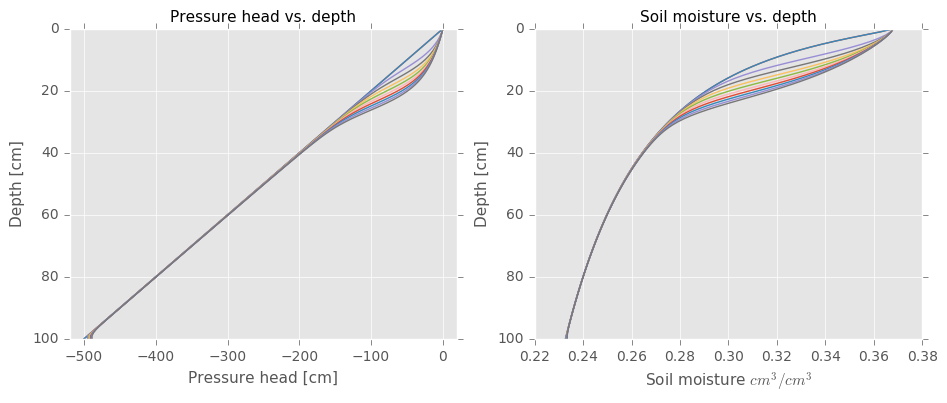

In [247]:
fig = plt.figure(1, figsize = (11,4)); 
ax = plt.subplot(121)
plt.plot(hinit,z);
plt.xlabel('Pressure head [cm]',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.xlim( np.min(H)-20,  np.max(H)+20)
plt.ylim(100, 0)
plt.gca().invert_yaxis()
plt.title('Pressure head vs. depth', fontsize=  11)
plt.ylim(100, 0)
ax = plt.subplot(122)
plt.plot(thetainit,z)
plt.xlabel('Soil moisture $cm^3/cm^3$',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.gca().invert_yaxis()
plt.title('Soil moisture vs. depth',fontsize=  11)

for i in  range(10):
    ax = plt.subplot(121)
    plt.plot(H[:, i],z)
    ax = plt.subplot(122)
    plt.plot(THETA[:, i],z)
fig.savefig('vary_stop_tol/profile {0}.pdf'.format(printstr))

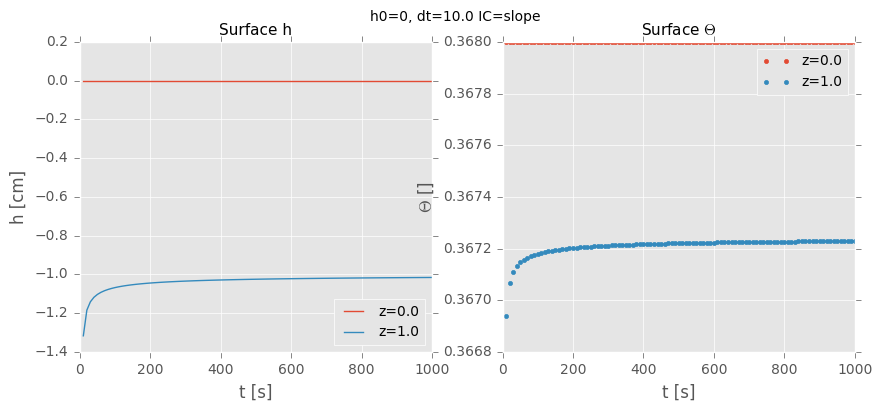

In [248]:
fig  = plt.figure(1, figsize = (10,4)); 
ax = plt.subplot(121)
plt.title('Surface h',  fontsize = 11)
plt.plot(t[1:], H[0, 1:], label = 'z={}'.format(z[0]))
plt.plot(t[1:], H[1, 1:], label = 'z={}'.format(z[1]))
plt.xlabel('t [s]'); plt.ylabel('h [cm]')
plt.legend(loc = 'best', fontsize = 10)
ax = plt.subplot(122)
plt.title('Surface $\Theta$',  fontsize = 11)
plt.plot(t[1:], THETA[0, 1:], '.', label = 'z={}'.format(z[0]))
plt.plot(t[1:], THETA[1, 1:], '.', label = 'z={}'.format(z[1]))
plt.legend(loc = 'best', fontsize = 10)
plt.xlabel('t [s]'); plt.ylabel('$\Theta$ []')
plt.suptitle('{}'.format(fmtstr))
# fig.savefig('fluxplots/surface_{0}.pdf'.format(printstr))

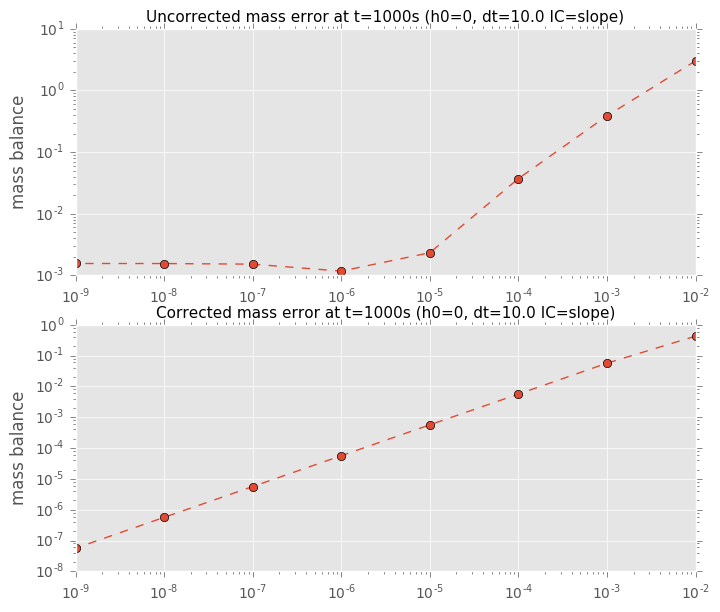

In [249]:
fig = plt.figure(figsize= (8,7))

plt.subplot(211)
plt.loglog(stop_tols[:], np.abs(np.array(mass_balance)), 'o--')
plt.ylabel("mass balance")
plt.title('Uncorrected mass error at t={1:.0f}s ({0})'.format(fmtstr, (tmax)), fontsize = 11)

plt.subplot(212)
plt.loglog(stop_tols[:], np.abs(np.array(balance_w_err)), 'o--')
plt.ylabel("mass balance")
plt.title('Corrected mass error at t={1:.0f}s ({0})'.format(fmtstr, (tmax)), fontsize = 11)
fig.savefig('vary_stop_tol/mass error {0}.pdf'.format(printstr))

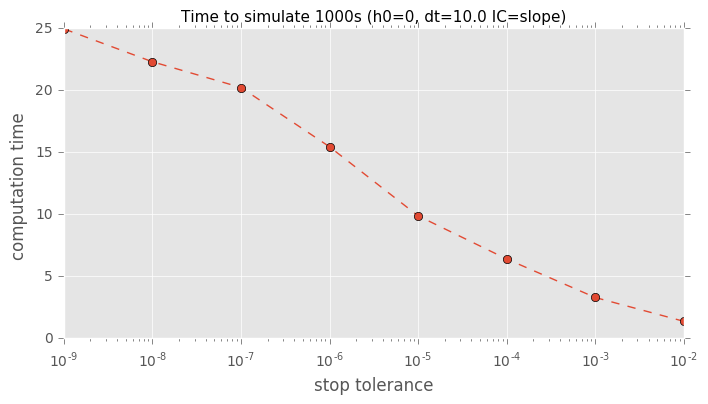

In [250]:
fig = plt.figure(figsize= (8,4))

# plt.subplot(211)
plt.semilogx(stop_tols, time_elapse, 'o--')
plt.xlabel("stop tolerance")
plt.ylabel("computation time ")
plt.title('Time to simulate {1}s ({0})'.format(fmtstr, int(tmax)), fontsize = 11)
# fig.savefig('vary_stop_tol/time elapse {0}.pdf'.format(printstr))